In [1]:
import numpy as np
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from datetime import datetime, date, time, timedelta
from collections import Counter
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Video Game Sales and Ratings 

На первом этапе исследований я буду использовать следующий датасет с Kaggle: Video Game Sales and Ratings (https://www.kaggle.com/kendallgillies/video-game-sales-and-ratings). Он аккумулирует информацию с двух ресурсов: VGCharts (http://www.vgchartz.com), который содержит базу данных по продажам видеоигр в различных регионах, и Metacritic (https://www.metacritic.com) — агрегатора рецензий критиков с возможностью пользователей выставлять свои оценки и отзывы. Данные верны на январь 2017 года.

In [2]:
df_kaggle = pd.read_csv("./data/Video_Game_Sales_as_of_Jan_2017.csv")

In [3]:
df_kaggle.head(10)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,76.0,51.0,8.0,324.0,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.80,3.79,3.29,35.57,82.0,73.0,8.3,712.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.28,2.95,32.78,80.0,73.0,8.0,193.0,E
4,Pokemon Red/Pokemon Blue,G,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN
5,Tetris,G,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.15,6.50,2.88,29.81,89.0,65.0,8.5,433.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.48,6.95,4.70,2.25,28.38,87.0,80.0,8.4,595.0,E
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN,NaN,NaN


Судя по данным, первично выкачка проходила именно с сайта VGCharts — в датасете присутствуют тайтлы с таких платформ, как Gameboy, Atari 2600 и Nintendo Entertainment System, которых нет на Metacritic. Поэтому в этих строчках отсутствует информация по поводу оценок критиков и пользователей, а также возрастного рейтинга, которая была получена именно с Metacritic.

In [4]:
print(df_kaggle.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17416 entries, 0 to 17415
Data columns (total 15 columns):
Name               17416 non-null object
Platform           17416 non-null object
Year_of_Release    17408 non-null float64
Genre              17416 non-null object
Publisher          17415 non-null object
NA_Sales           17416 non-null float64
EU_Sales           17416 non-null float64
JP_Sales           17416 non-null float64
Other_Sales        17416 non-null float64
Global_Sales       17416 non-null float64
Critic_Score       8336 non-null float64
Critic_Count       8336 non-null float64
User_Score         7798 non-null float64
User_Count         7798 non-null float64
Rating             10252 non-null object
dtypes: float64(10), object(5)
memory usage: 2.0+ MB
None


В опубликованную версию датасета попали не все позиции с VGCharts, а только те, число глобальных продаж которых превосходит десять тысяч копий (точность отображения — одна сотая миллиона). Стоит заметить, что база данных сайта не делает различий между отсутствием данных о продажах и слишком малыми продажами. С учётом масштабов разумно также предположить, что в абсолютном большинстве случаев отсутствие игры в таблице означает именно отсутствие данных.

In [5]:
df_kaggle = df_kaggle.drop(['Critic_Count', 'User_Count'], axis='columns')

В качестве первичной предобработки данных избавимся от информации о количестве рецензий и количестве отзывов пользователей. В первом будем следовать за политикой самого Metacritic — агрегированная оценка отображается на нём лишь после появления как минимум четырёх рецензий; игры, которые не набрали такого количества, просто не имеют средней оценки. 

Исследование будет посвящено изучению влияния различных факторов на продажи и критику проектов.

Для начала изучим распределение продаж по годам выхода проектов суммарно и в среднем.

In [6]:
dates = df_kaggle.Year_of_Release.unique()
index = np.argwhere(dates is nan)
dates = np.delete(dates, index)
dates = np.sort(dates)

In [7]:
total_N = np.zeros(dates.size)
total_sales = np.zeros(dates.size)
mean_sales = np.zeros(dates.size)

for ind in range(dates.size):
    total_N[ind] = df_kaggle[df_kaggle['Year_of_Release'] == dates[ind]].size
    total_sales[ind] = df_kaggle[df_kaggle['Year_of_Release'] == dates[ind]]['Global_Sales'].sum()
    mean_sales[ind] = df_kaggle[df_kaggle['Year_of_Release'] == dates[ind]]['Global_Sales'].mean()

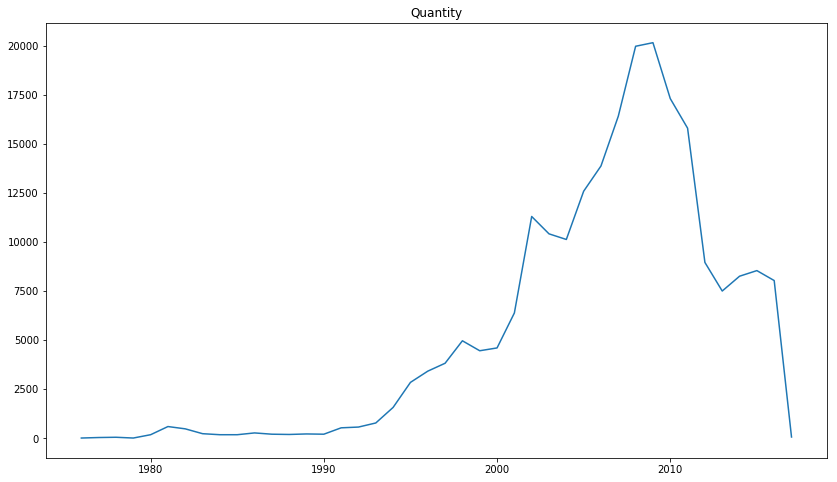

In [8]:
fig = plt.figure(figsize=(14, 8))
plt.title("Quantity")
plt.plot(dates, total_N)

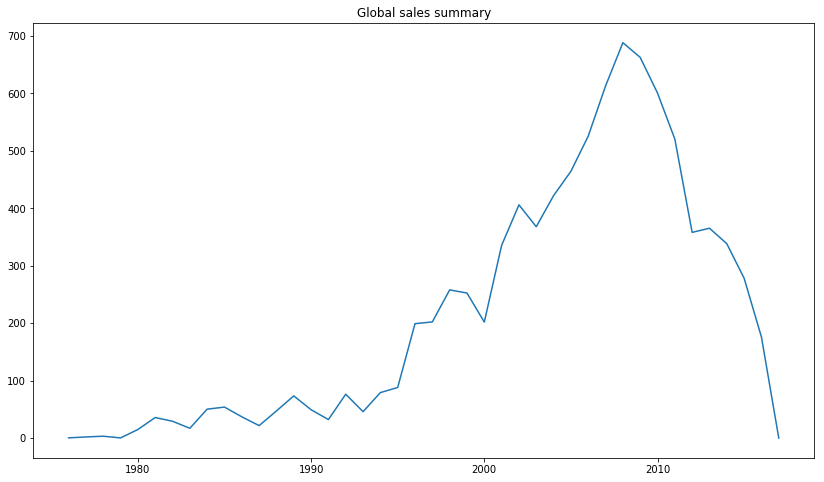

In [9]:
fig = plt.figure(figsize=(14, 8))
plt.title("Global sales summary")
plt.plot(dates, total_sales)

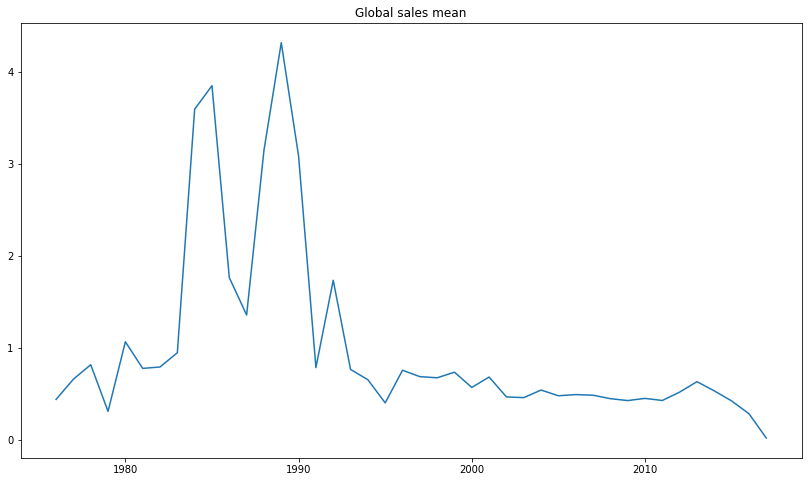

In [10]:
fig = plt.figure(figsize=(14, 8))
plt.title("Global sales mean")
plt.plot(dates, mean_sales)

Разница между левой половиной графика и правой вызвана в первую очередь тем, что данные о проектах XX века заполнялись постфактум на момент создания сайта и в базу попадали преимущественно известные и хорошо продавшиеся проекты (в том числе потому, что найти столь тонкую информацию о малоизвестных тайтлах непросто), в то время как данные XXI века включают в себя большие объёмы находящейся в открытом доступе информации о проектах всех масштабов. 

Спад в правом конце вызван тем, что таблица содержит данные о продажах с момента релиза до января 2017 года; вышедшие, например, в конце 2016 проекты не успели пережить достаточное количество распродаж и акций в магазинах для того, чтобы набрать сравнимые с их предшественниками продажи.

Поэтому далее будем рассматривать период шестого и седьмого консольного поколения. Во-первых, он должен быть достаточно хорошо задокументирован. Во-вторых, тайтлы этих лет незначительно увеличивают объёмы продаж в наше время. В хронологии возьмём в рассмотрение 2001 — 2014 годы выхода проектов. Исключим из списка SEGA Dreamcast, поскольку его судьба на рынке была слишком специфична (релиз состоялся в 1998-1999 годах, поддержка была прекращена в 2001, в то время как остальные представители поколения в 2001 году только выходили в продажу).

In [11]:
df_kaggle.Platform.unique()

array(['Wii', 'NES', 'G', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'X', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [12]:
consoles_6gen = ['GBA', 'PS2', 'GC', 'X'] #'DC'
consoles_7gen = ['Wii', 'DS', 'X360', 'PS3', 'PSP'] 

In [13]:
con_list = consoles_6gen + consoles_7gen + ['PC']

df_con = df_kaggle[df_kaggle['Platform'].isin(con_list)]
df_con = df_con[(2001 <= df_con['Year_of_Release']) & (df_con['Year_of_Release'] <= 2014)]

In [14]:
df_con.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.80,3.79,3.29,35.57,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.28,2.95,32.78,80.0,8.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.15,6.50,2.88,29.81,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,6.6,E


In [15]:
df_con.shape[0]

12687

In [16]:
dates = df_con.Year_of_Release.unique()
index = np.argwhere(dates == nan)
dates = np.delete(dates, index)
dates = np.sort(dates)

In [17]:
total_N = np.zeros(dates.size)
gen6_N = np.zeros(dates.size)
gen7_N = np.zeros(dates.size)
PC_N = np.zeros(dates.size)
total_sales = np.zeros(dates.size)
gen6_total_sales = np.zeros(dates.size)
gen7_total_sales = np.zeros(dates.size)
PC_total_sales = np.zeros(dates.size)
mean_sales = np.zeros(dates.size)
gen6_mean_sales = np.zeros(dates.size)
gen7_mean_sales = np.zeros(dates.size)
PC_mean_sales = np.zeros(dates.size)
mean_score = np.zeros(dates.size)
gen6_mean_score = np.zeros(dates.size)
gen7_mean_score = np.zeros(dates.size)
PC_mean_score = np.zeros(dates.size)

for ind in range(dates.size):
    total_N[ind] = df_con[df_con['Year_of_Release'] == dates[ind]].size
    gen6_N[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_6gen))].size
    gen7_N[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_7gen))].size
    PC_N[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'] == 'PC')].size
    total_sales[ind] = df_con[df_con['Year_of_Release'] == dates[ind]]['Global_Sales'].sum()
    gen6_total_sales[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_6gen))]['Global_Sales'].sum()
    gen7_total_sales[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_7gen))]['Global_Sales'].sum()
    PC_total_sales[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'] == 'PC')]['Global_Sales'].sum()
    mean_sales[ind] = df_con[df_con['Year_of_Release'] == dates[ind]]['Global_Sales'].mean()
    gen6_mean_sales[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_6gen))]['Global_Sales'].mean()
    gen7_mean_sales[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_7gen))]['Global_Sales'].mean()
    PC_mean_sales[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'] == 'PC')]['Global_Sales'].mean()
    mean_score[ind] = df_con[df_con['Year_of_Release'] == dates[ind]]['Critic_Score'].mean()
    gen6_mean_score[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_6gen))]['Critic_Score'].mean()
    gen7_mean_score[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'].isin(consoles_7gen))]['Critic_Score'].mean()
    PC_mean_score[ind] = df_con[(df_con['Year_of_Release'] == dates[ind]) & \
                (df_con['Platform'] == 'PC')]['Critic_Score'].mean()

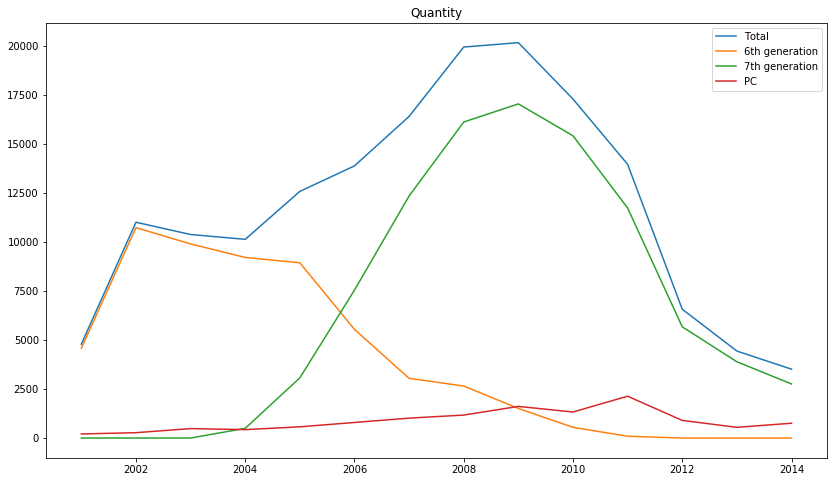

In [18]:
fig = plt.figure(figsize=(14, 8))
plt.title("Quantity")
plt.plot(dates, total_N, label="Total")
plt.plot(dates, gen6_N, label="6th generation")
plt.plot(dates, gen7_N, label="7th generation")
plt.plot(dates, PC_N, label="PC")
plt.legend()

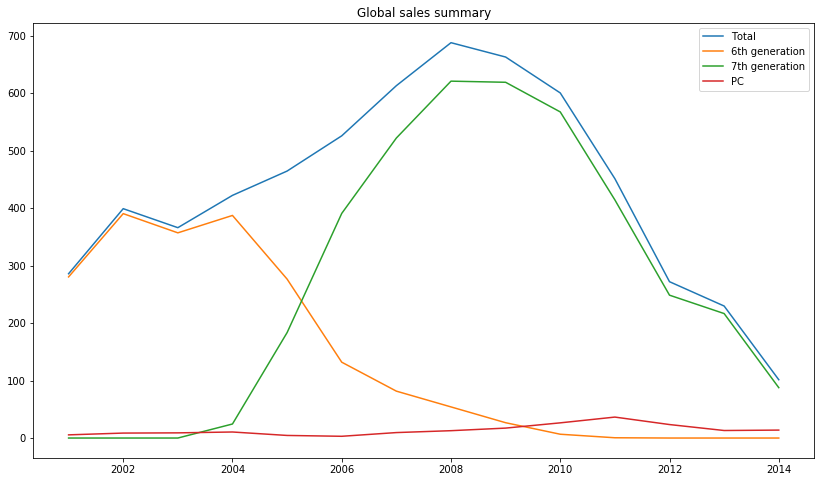

In [19]:
fig = plt.figure(figsize=(14, 8))
plt.title("Global sales summary")
plt.plot(dates, total_sales, label="Total")
plt.plot(dates, gen6_total_sales, label="6th generation")
plt.plot(dates, gen7_total_sales, label="7th generation")
plt.plot(dates, PC_total_sales, label="PC")
plt.legend()

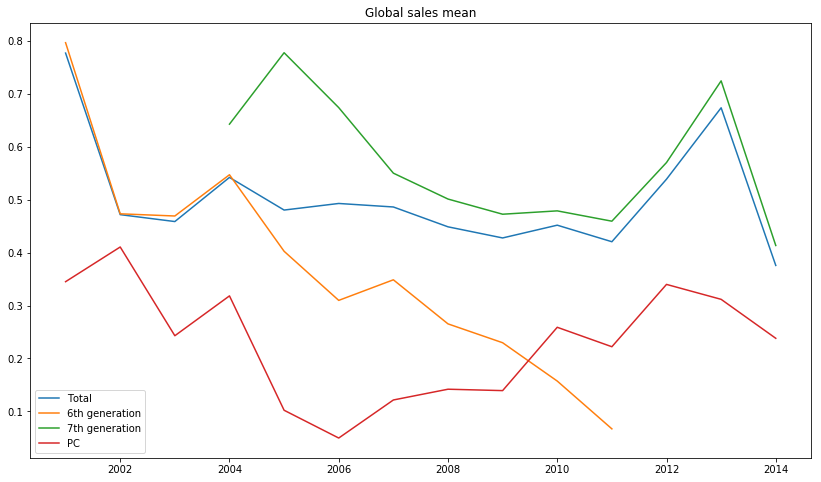

In [20]:
fig = plt.figure(figsize=(14, 8))
plt.title("Global sales mean")
plt.plot(dates, mean_sales, label="Total")
plt.plot(dates, gen6_mean_sales, label="6th generation")
plt.plot(dates, gen7_mean_sales, label="7th generation")
plt.plot(dates, PC_mean_sales, label="PC")
plt.legend()

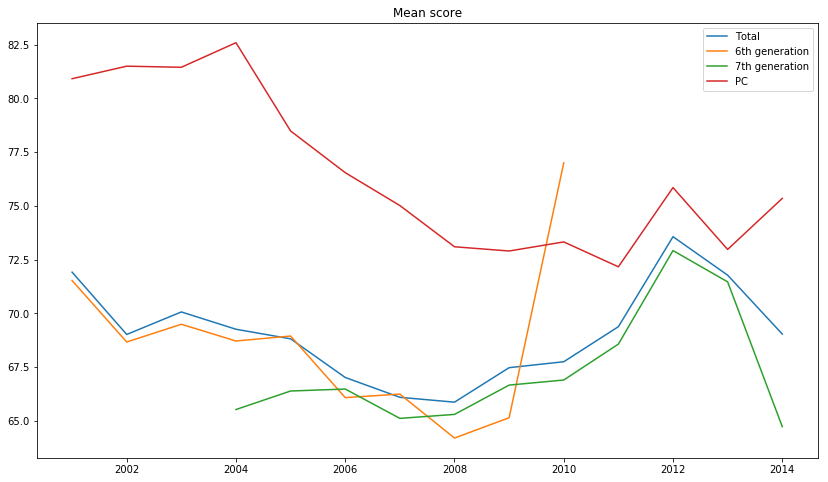

In [21]:
fig = plt.figure(figsize=(14, 8))
plt.title("Mean score")
plt.plot(dates, mean_score, label="Total")
plt.plot(dates, gen6_mean_score, label="6th generation")
plt.plot(dates, gen7_mean_score, label="7th generation")
plt.plot(dates, PC_mean_score, label="PC")
plt.legend()

# Гипотеза 1

Выдвинем следующую гипотезу: средняя оценка игры не зависит от жанра.

In [22]:
df_con_scored = df_con[df_con['Critic_Score'].notnull()]

In [23]:
df_con_scored.shape[0]

7110

In [24]:
genres = df_con_scored.Genre.unique()

In [25]:
genres

array(['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Puzzle',
       'Shooter', 'Fighting', 'Simulation', 'Role-Playing', 'Adventure',
       'Strategy'], dtype=object)

In [26]:
df_con_scored.Genre.value_counts()

Action          1586
Sports          1066
Shooter          848
Racing           663
Role-Playing     607
Misc             467
Platform         424
Fighting         356
Simulation       322
Strategy         281
Adventure        280
Puzzle           210
Name: Genre, dtype: int64

In [27]:
genre_list_of_scores = [df_con_scored[df_con_scored['Genre'] == genre]\
                        ['Critic_Score'].values for genre in genres]

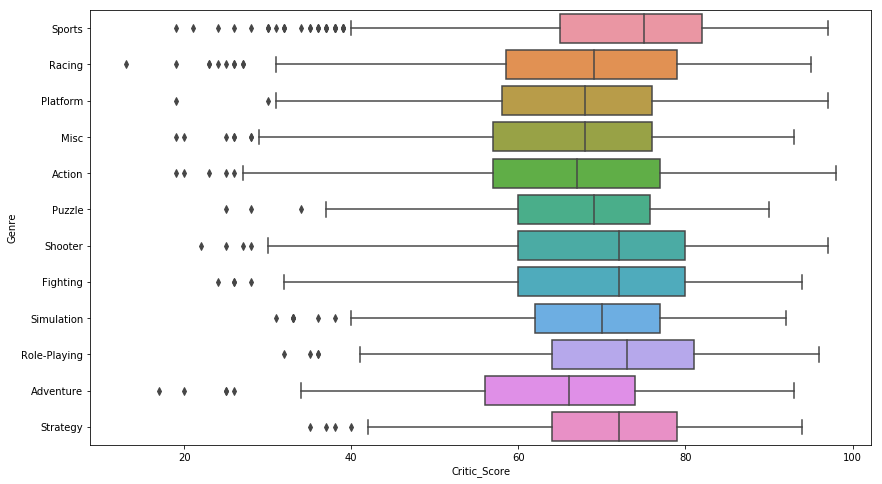

In [28]:
fig = plt.figure(figsize=(14, 8))
sns.boxplot(y="Genre", x="Critic_Score", data=df_con_scored, orient="h")

In [29]:
genres_cut_list = []
N = genres.size
for ind1 in range(N):
    for ind2 in range(ind1 + 1, N):
        for ind3 in range(ind2 + 1,N):
            for ind4 in range(ind3 + 1, N):
                genres_cut_list.append([genres[ind1], genres[ind2],
                                       genres[ind3], genres[ind4]])

In [30]:
genres_cut = genres_cut_list[0]

In [31]:
genre_list_of_scores_cut = [df_con_scored[df_con_scored['Genre'] == genre]\
                        ['Critic_Score'].values for genre in genres_cut]

Для простоты будем действовать в предположении о том, что выборки принадлежат одному и тому же распределению: остальные параметры, влияющие на качество конечного продукта, будь то техническая составляющая, оригинальность геймплея или самобытность стиля проекта, могут в равной степени быть реализованы в проекте любого жанра (баланс чего в действительности меняется от жанра к жанру).

Гипотеза H0 — выборки имеют одинаковые медианы. H1 — разные. Для проверки воспользуемся критерием Краскела-Уоллиса.

In [32]:
sample_groups = []
[sample_groups.append(np.random.choice(genre_list_of_scores_cut[x], size = 10)) for x in range(4)]
sample_groups

[array([61., 75., 88., 85., 45., 74., 82., 84., 78., 79.]),
 array([84., 72., 40., 44., 75., 89., 50., 57., 72., 70.]),
 array([76., 77., 56., 60., 95., 51., 67., 69., 62., 71.]),
 array([72., 82., 30., 75., 38., 63., 55., 51., 62., 70.])]

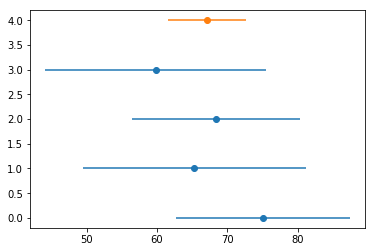

In [33]:
x = [l.mean() for l in sample_groups]
y = np.arange(len(sample_groups))
e = [l.std() for l in sample_groups]

plt.errorbar(x, y, xerr = e, linestyle='None', marker='o')

plt.errorbar(np.mean(x), len(y), xerr = np.std(x), linestyle='None', marker='o')

plt.show()

In [34]:
F, p = stats.kruskal(sample_groups[0], sample_groups[1], sample_groups[2], sample_groups[3])

In [35]:
p

0.11413203952073359

In [36]:
ans = []
for genres_cut in genres_cut_list:
    genre_list_of_scores_cut = [df_con_scored[df_con_scored['Genre'] == genre]\
                        ['Critic_Score'].values for genre in genres_cut]
    sample_groups = []
    [sample_groups.append(np.random.choice(genre_list_of_scores_cut[x], size = 10)) 
                                                                 for x in range(4)]
    F, p = stats.kruskal(sample_groups[0], sample_groups[1], sample_groups[2], sample_groups[3])
    ans.append(p)

In [37]:
boundary = 0.05

true_count = 0
false_count = 0
for item in ans:
    if item >= boundary:
        true_count += 1
    else:
        false_count += 1
        
print(f"{true_count} groups that have common median, {false_count} groups that have different median")

438 groups that have common median, 57 groups that have different median


Для 88% процентов наборов жанров имеем $p > 0.05$. С учётом того, что подвыборки по 10 элементов из выборок брались случайно, сделаем вывод о том, что средняя оценка игры незначительно зависит от такого фактора, как жанр.

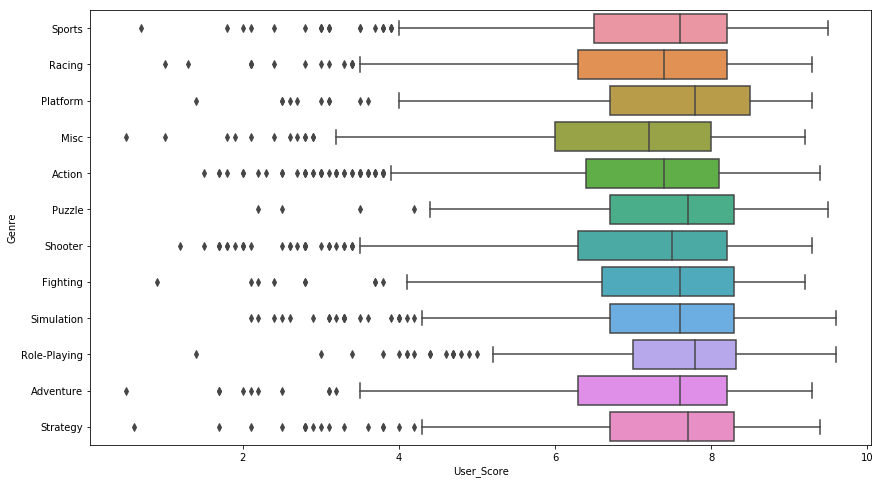

In [38]:
fig = plt.figure(figsize=(14, 8))
sns.boxplot(y="Genre", x='User_Score', data=df_con_scored, orient="h")

In [39]:
ans = []
for genres_cut in genres_cut_list:
    genre_list_of_Uscores_cut = [df_con_scored[df_con_scored['Genre'] == genre]\
                        ['User_Score'].values for genre in genres_cut]
    sample_groups = []
    [sample_groups.append(np.random.choice(genre_list_of_Uscores_cut[x], size = 10)) 
                                                                 for x in range(4)]
    F, p = stats.kruskal(sample_groups[0], sample_groups[1], sample_groups[2], sample_groups[3])
    ans.append(p)
    
boundary = 0.05

true_count = 0
false_count = 0
for item in ans:
    if item >= boundary:
        true_count += 1
    else:
        false_count += 1
        
print(f"{true_count} groups that have common median, {false_count} groups that have different median")

1 groups that have common median, 494 groups that have different median


Аналогичное исследование для оценок пользователей даёт совершенно противоположный результат, отвергая H0 и принимая противоположную ей H1. Это может демонстрировать как отражение активности аудитории тех или иных жанров в среде форумной части сервиса, так и отражать некоторую её неадекватность — в сообществе нередки истории о том, как различные группы фанатов совершали "набеги" на страницы тех или иных игр, занижая или завышая общую оценку рядами "нулей" и "десяток", создавая выбросы в данных.

# Гипотеза 2

Выдвинем следующую гипотезу: возрастной рейтинг не влияет на продажи.

In [40]:
df_con.Rating.value_counts()

E       3637
T       2605
M       1310
E10+    1212
EC         8
RP         3
AO         1
Name: Rating, dtype: int64

Рассмотрим два возрастных рейтига: M (Mature) и E10+ (Everyone 10+).

In [41]:
df_con_rated = df_con[df_con["Rating"].notnull()]
df_con_rated = df_con_rated[(df_con_rated["Rating"] == 'E10+') |
                            (df_con_rated["Rating"] == 'M')]

Будем считать "успешной по продажам" игру, имеющую более чем миллион покупок по всему миру.

In [42]:
q_all = df_con_rated.Rating.value_counts().values

In [43]:
q_succ = df_con_rated[df_con_rated["Global_Sales"] > 1.0].Rating.value_counts().values

In [44]:
q_M = np.array([q_succ[0], q_all[0]])
q_Eten = np.array([q_succ[1], q_all[1]])
print(f"E10+: {q_Eten}, M: {q_M}")

E10+: [ 141 1212], M: [ 272 1310]


$np$ и $n(1 − p)$ превосходят 5 для обеих групп. Воспользуемся Z-критерием для проверки H0 — доля "успешных" релизов среди всех не зависит от возрастного рейтинга, H1 — зависит.

In [45]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(q_Eten, q_M, alternative='two-sided')

(-17.351886747732046, 1.908710008549323e-67)

Таким образом, нулевая гипотеза отвергнута и возрастной рейтинг действительно влияет на коммерческий успех игры.

# Metacritic Date of Release

Для предсказания временного ряда воспользуемся другим датасетом. Он был получен после моего собственного парсинга Metacritic (код находится в блокноте MetacriticParser).

In [47]:
df_date = pd.read_excel("./data/Metacritic_date_of_release.xlsx")
df_date.head()

,Name,Platform,Date_of_Release
0,FROST,iOS,"Oct 25, 2017"
1,Halcyon 6: Starbase Commander,iOS,"Oct 19, 2017"
2,Game of Thrones: Conquest,iOS,"Oct 19, 2017"
3,Time Recoil,iOS,"Oct 18, 2017"
4,Whirl Tour,PlayStation 2,"Nov 25, 2002"


In [48]:
def to_date(s):
    try:
        ans = datetime.strptime(s, "%b %d, %Y")
        return ans
    except:
        return None

In [49]:
df_date["Date_of_Release"] = df_date["Date_of_Release"].apply(to_date)

In [50]:
df_date = df_date[pd.notnull(df_date["Date_of_Release"])]

In [51]:
df_date["Date_of_Release"] = df_date["Date_of_Release"].dt.to_period('M')

In [52]:
lower_bound = datetime(2001, 1, 1)
upper_bound = datetime(2018, 11, 1)

dates = [v.to_timestamp() for v in df_date["Date_of_Release"].values 
                     if lower_bound < v.to_timestamp() < upper_bound]

Ограничим рассматриваемые периоды времени. Как уже упоминалось, Metacritic содержит лишь часть платформ из пятого и предшествующих поколений консолей, поэтому данные по количеству релизов в этой области плохо отражают действительность. С другой стороны, далеко не все из выходящих в 2019 продуктов уже получили дату релиза или были анонсированы широкой общественности.

In [53]:
dates.sort()

In [54]:
X = list(Counter(dates).keys())
y = list(Counter(dates).values())

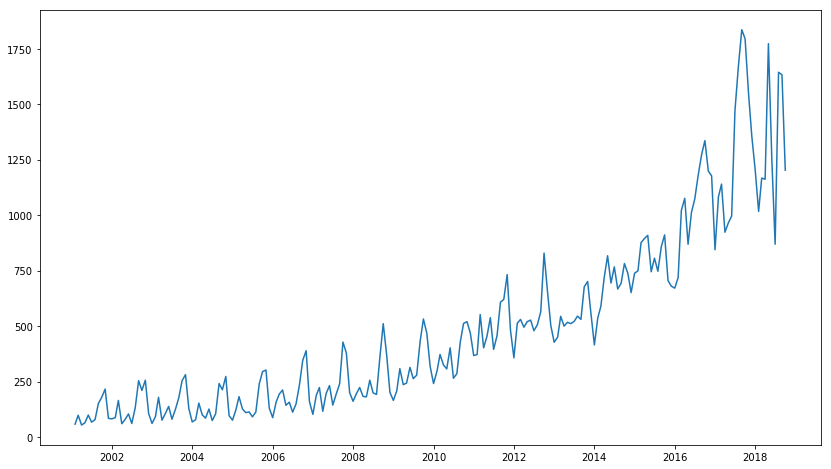

In [55]:
fig = plt.figure(figsize=(14, 8))
plt.plot(X, y)
plt.show()

Из графика видно, что, вопреки повышающемуся порогу качества, который увеличивает средний срок разработки игр, и повышающемуся порогу входа, вызванному существованием крупных студий и компаний с огромными бюджетами и уже сформировавшейся аудиторией, среднее количество релизов растёт с течением времени.

In [56]:
cut_bound = len(X) * 19 // 20
X_train = X[:cut_bound + 1]
X_test = X[cut_bound:]
y_train = y[:cut_bound + 1]
y_test = y[cut_bound:]

In [57]:
rms_best = None

for sl in np.arange(0, 1, 0.1):
    for ss in np.arange(0, 1, 0.1):
        fit = ExponentialSmoothing(np.asarray(y_train), seasonal_periods=12, seasonal='add')\
                                .fit(smoothing_level = sl, smoothing_slope = ss)
        y_pred = fit.forecast(len(y_test))
        rms = mean_squared_error(y_test, y_pred)
        
        if (rms_best is None) or (rms < rms_best):
            sl_best = sl
            ss_best = ss
            rms_best = rms

In [58]:
rms_best = None

for sl in np.arange(0, 1, 0.1):
    for ss in np.arange(0, 1, 0.1):
        fit = Holt(np.asarray(y_train)).fit(smoothing_level = sl, smoothing_slope = ss)
        y_pred = fit.forecast(len(y_test))
        rms = mean_squared_error(y_test, y_pred)
        
        if (rms_best is None) or (rms < rms_best):
            sl_best_l = sl
            ss_best_l = ss
            rms_best = rms

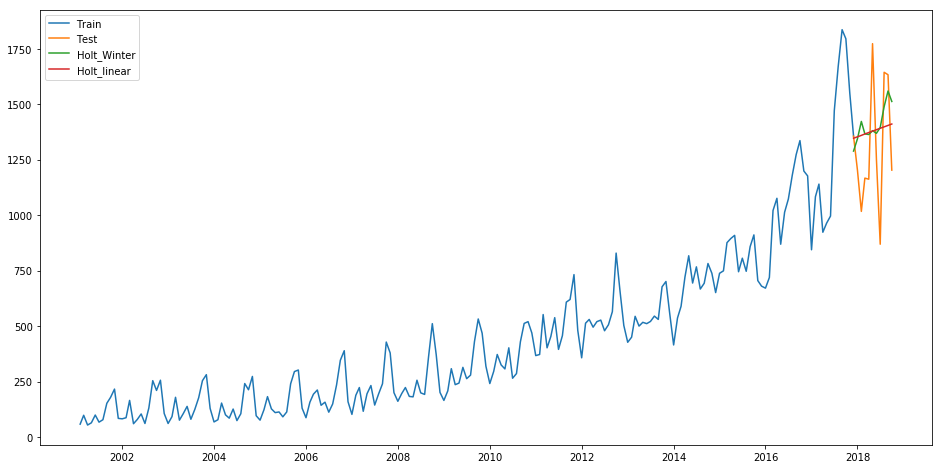

In [59]:
y_pred = {}
fit1 = ExponentialSmoothing(np.asarray(y_train), seasonal_periods=12, seasonal='add')\
                                .fit(smoothing_level = sl_best, smoothing_slope = ss_best)
fit2 = Holt(np.asarray(y_train)).fit(smoothing_level = sl_best_l, smoothing_slope = ss_best_l)
y_pred['Holt_Winter'] = fit1.forecast(len(y_test))
y_pred['Holt_linear'] = fit2.forecast(len(y_test))
plt.figure(figsize=(16,8))
plt.plot(X_train, y_train, label='Train')
plt.plot(X_test, y_test, label='Test')
plt.plot(X_test, y_pred['Holt_Winter'], label='Holt_Winter')
plt.plot(X_test, y_pred['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [60]:
X_pred = [X_test[-1] + i * timedelta(days=60) for i in range(6)]

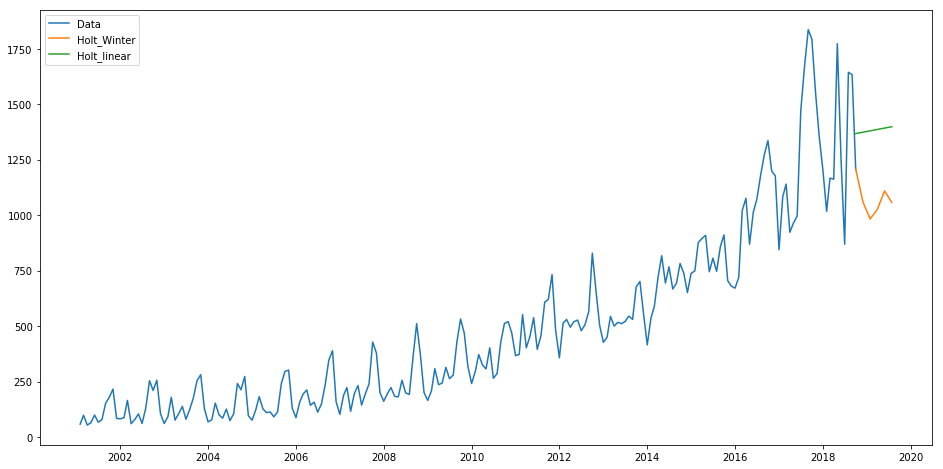

In [61]:
y_pred = {}
fit1 = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, seasonal='add')\
                                .fit(smoothing_level = sl_best, smoothing_slope = ss_best)
fit2 = Holt(np.asarray(y)).fit(smoothing_level = sl_best_l, smoothing_slope = ss_best_l)
y_pred['Holt_Winter'] = fit1.forecast(len(X_pred))
y_pred['Holt_linear'] = fit2.forecast(len(X_pred))
plt.figure(figsize=(16,8))
plt.plot(X, y, label='Data')
plt.plot(X_pred, y_pred['Holt_Winter'], label='Holt_Winter')
plt.plot(X_pred, y_pred['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

Предсказания временного ряда на 2019 методом Холта-Уинтера выглядят правдоподобно: постепенно наступает закат текущего поколения консолей (выход новых устройств от гигантов Xbox и PlayStation прогнозируют на конец 2019-2020), и количество релизов на современные платформы соответственно спадает.

# Summary

Получение какой-либо более глобальной картины происходящего сопряжено с более глубокими исследованиями и более серьёзным анализом имеющихся данных. На данном этапе можно лишь отметить, что для критиков жанровая принадлежность проекта не имеет серьёзного значения, тогда как аудитория фанатов наоборот сдвигает чашу весов в пользовательской оценке Metacritic в ту или иную сторону; возрастной рейтинг же оказывает заметное влияние на продажи и, возможно, издателям стоит обращать больше внимания на удовлетворение требований ESRB и комиссий других регионов.